In [1]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import gc
import random
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset

# Ensure the parent directory is in the path to find 'model/' folder
sys.path.append("..")

# --- Imports from your structure ---
try:
    from model.long import LongConfig, LongForCausalLM
    from transformers import MambaConfig, MambaForCausalLM
    from transformers import GPT2Config, GPT2LMHeadModel
except ImportError:
    print("Warning: Custom model modules (Holo/Long) not found. Ensure 'model' folder is in path.")

# Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on device: {device}")

Running on device: cuda


In [2]:
def set_seed(seed = 42):
    """
    Sets the seed for reproducibility across all libraries.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior for CUDA (slightly slower but 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"🌱 Seed set to {seed}")

In [3]:
class ListOpsGenerator:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        
        # <PAD> is at index 0
        # MIN, MAX, MED (median), SM (sum modulo 10)
        self.tokens = ["<PAD>", "[", "]", "MIN", "MAX", "MED", "SM"] + \
                         [str(i) for i in range(10)]
        self.vocab = {t: i for i, t in enumerate(self.tokens)}
        self.rev_vocab = {i: t for t, i in self.vocab.items()}
        
        self.PAD_TOKEN_ID = 0      # Use this for INPUTS (Embedding layer)
        self.IGNORE_INDEX = -100   # Use this for TARGETS (Loss function) - Not used for single answer, but good practice

    
    def generate_tree(self, current_depth):
        # Base case: depth 0 or small random chance to stop early
        if current_depth == 0 or random.random() < 0.1:
            return str(random.randint(0, 9))
        
        op = random.choice(["MIN", "MAX", "MED", "SM"])
        # Reduce max children slightly to keep length manageable
        num_children = random.randint(2, 4) 
        children = [self.generate_tree(current_depth - 1) for _ in range(num_children)]
        return f"[{op} " + " ".join(children) + "]"

    
    def solve(self, sequence):
        # FIX: Add spaces around brackets so they split into separate tokens!
        # [MIN 8 4] -> ( MIN 8 4 ) -> ['(', 'MIN', '8', '4', ')']
        tokens = sequence.replace("[", " ( ").replace("]", " ) ").split()
        
        def parse(toks):
            token = toks.pop(0)
            if token == "(":
                op = toks.pop(0)
                vals = []
                while toks[0] != ")":
                    vals.append(parse(toks))
                toks.pop(0) # Remove )
                
                if op == "MIN": return min(vals)
                if op == "MAX": return max(vals)
                if op == "MED": return int(np.median(vals))
                if op == "SM": return sum(vals) % 10
            else:
                return int(token)
        try:
            return parse(tokens.copy())
            
        except Exception as e:
            # Print the actual error message for debugging next time
            print(f"Solver failed on: {sequence} | Error: {e}")
            return None

    
    def generate_sample(self, target_length):
        while True:
            depth = random.randint(2, self.max_depth)
            seq_str = self.generate_tree(depth)

            # Tokenize
            token_strs = seq_str.replace("[", " [ ").replace("]", " ] ").split()
            tokens = [self.vocab[t] for t in token_strs]
            
            if len(tokens) < target_length:
                break
        
        answer = self.solve(seq_str)
        if answer is None:
            return self.generate_sample(target_length)

        # 1. Input: The Sequence + 1 Padding token (placeholder for answer generation)
        #    We assume the model sees "]" and then predicts the answer.
        #    So we need an input position *after* "]" to hold the gradient for the answer.

        # Current tokens: [ ... ]
        # We append PAD to inputs so there is a position corresponding to the answer label.
        input_ids = tokens + [self.PAD_TOKEN_ID]

        # 2. Targets: Ignore everything until the very last token
        target_ids = [self.IGNORE_INDEX] * len(tokens)
        target_ids.append(self.vocab[str(answer)])

        # 3. Padding to fixed length
        padding_needed = target_length - len(input_ids)
        if padding_needed > 0:
            input_ids += [self.PAD_TOKEN_ID] * padding_needed
            target_ids += [self.IGNORE_INDEX] * padding_needed
        
        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(target_ids, dtype=torch.long)
        


In [4]:
class ListOpsStaticDataset(Dataset):
    def __init__(self, generator, num_samples, length):
        self.generator = generator
        self.length = length
        self.samples = []
        
        # PRE-GENERATE data so it stays fixed
        print(f"    ...Pre-generating {num_samples} samples of length {length}...")
        for _ in range(num_samples):
            self.samples.append(self.generator.generate_sample(self.length))

    def __len__(self):
        return len(self.samples)        

    def __getitem__(self, idx):
        # Return the saved sample (Input, Target)
        return self.samples[idx]

In [5]:
def decode_and_display(generator, input_ids, target_ids):
    # 1. Convert tensors to standard python lists
    input_list = input_ids.tolist()
    target_list = target_ids.tolist()

    decoded_tokens = []
    for tid in input_list:
        if tid == generator.PAD_TOKEN_ID:
            break
        decoded_tokens.append(generator.rev_vocab.get(tid, "<UNK>"))

    expression = " ".join(decoded_tokens)

    # The target tensor is mostly -100 (IGNORE_INDEX). We find the one valid value.
    answer_token = None
    for tid in target_list:
        if tid != generator.IGNORE_INDEX:
            answer_token = generator.rev_vocab.get(tid, "<UNK>")
            break

    # 4. Print
    print(f"🔹 Expression: {expression}")
    if answer_token:
        print(f"🔸 Target:     {answer_token}")
    else:
        print(f"🔸 Target:     (None found - check data generation!)")
    print("-" * 40)

In [6]:
generator = ListOpsGenerator(max_depth=5) # Adjust depth based on length if needed

lops = ListOpsStaticDataset(generator, num_samples = 100, length = 20)

    ...Pre-generating 100 samples of length 20...


In [7]:
generator.vocab

{'<PAD>': 0,
 '[': 1,
 ']': 2,
 'MIN': 3,
 'MAX': 4,
 'MED': 5,
 'SM': 6,
 '0': 7,
 '1': 8,
 '2': 9,
 '3': 10,
 '4': 11,
 '5': 12,
 '6': 13,
 '7': 14,
 '8': 15,
 '9': 16}

In [8]:
inp, out = lops[1]
print(inp)
print(out)

decode_and_display(generator, inp, out)

tensor([ 1,  6,  1,  6, 12, 13,  2,  1,  5,  9, 14, 16,  2,  1,  6, 11, 15,  2,
         2,  0])
tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100,    7])
🔹 Expression: [ SM [ SM 5 6 ] [ MED 2 7 9 ] [ SM 4 8 ] ]
🔸 Target:     0
----------------------------------------


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model(model_name, vocab_size, max_seq_len, 
              hidden_dim=128, num_layers=6, num_heads=4, device='cuda'):
    """
    Initializes models with flexible configuration.
    Default (ListOps Baseline): DIM=128, LAYERS=6, HEADS=4
    """
    
    # Ensure GPT-2/Transformer position embeddings fit the data
    safe_max_pos = max(max_seq_len, 4096) 

    if model_name == "Long-LLM":
        config = LongConfig(
            vocab_size = vocab_size, 
            hidden_size = hidden_dim, 
            num_hidden_layers = num_layers, 
            num_heads = num_heads,
            max_position_embeddings = safe_max_pos,
            expansion_ratio = 8/3, 
            hybrid_ratio = 0,
            gate_init_bias = 0.0,
            # vital for long context 
            rope_base_dim = 1000000,
        )
        model = LongForCausalLM(config)

    elif model_name == "Mamba":
        config = MambaConfig(
            vocab_size = vocab_size,
            hidden_size = hidden_dim,
            num_hidden_layers = num_layers,
            ssm_cfg = {"dropout": 0.0},
            
            # Default state_size is 16 so we keep it here
        )
        model = MambaForCausalLM(config)

    elif model_name == "GPT-2":
        config = GPT2Config(
            vocab_size = vocab_size, 
            n_positions = safe_max_pos, 
            n_embd = hidden_dim, 
            n_layer = num_layers, 
            n_head = num_heads,
            resid_pdrop = 0.1, # Dropout when the model is large to prevent overfitting
            embd_pdrop = 0.1, 
            attn_pdrop = 0.1, 
            use_cache = False
        )
        model = GPT2LMHeadModel(config)
    else:
        raise ValueError(f"Unknown model: {model_name}")
        
    return model.to(device)

In [10]:
def train_model(model_name, model, train_loader, 
                epochs=20, lr=5e-4, max_grad_norm=1.0,
                pad_token = 0): 
    # Lowered LR
    model.train()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for batch_idx, (inputs, targets) in enumerate(loop):
            inputs, targets = inputs.to(device), targets.to(device)
                        
            optimizer.zero_grad()

            if model_name == "Mamba":
                outputs = model(input_ids=inputs, labels=targets)
            else:
                # 0 is the Padding token
                attention_mask = (inputs != pad_token).long()
                outputs = model(input_ids=inputs, 
                                attention_mask=attention_mask, 
                                labels=targets)
            
            loss = outputs.loss

            # Backprop
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            
            total_loss += loss.item()
            loop.set_postfix(loss=f"{total_loss/(batch_idx+1):.4f}")


In [11]:
def evaluate_model(model_name, model, test_loader, generator,
                   pad_token = 0,
                   ignore_index = -100):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            if model_name == "Mamba":
                outputs = model(input_ids=inputs, labels=targets)
            else:
                # 0 is the Padding token
                attention_mask = (inputs != pad_token).long()
                outputs = model(input_ids=inputs, 
                                attention_mask=attention_mask, 
                                labels=targets)

            logits = outputs.logits            
            # We constructed Targets specifically to align with Inputs.
            # Input:  [A, B, C, PAD]
            # Target: [-100, -100, -100, ANS]
            # If your dataset ALREADY aligned them, we compare directly.

            # Shift the HF way (Shift-by-one)
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = targets[:, 1:].contiguous()
            
            # 3. Get predictions (B, Seq_Len)
            preds = torch.argmax(shift_logits, dim=-1)
            
            # 4. Mask out the -100 positions in targets to calculate accuracy
            # This ensures we only compare valid tokens
            valid_mask = (shift_labels != ignore_index)
            
            # Compare only valid positions
            correct_preds = (preds == shift_labels) & valid_mask
            
            correct += correct_preds.sum().item()
            total += valid_mask.sum().item()
    
    return correct / total if total > 0 else 0

In [12]:
def print_model_stats(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # print(f"Model Structure:\n{model}\n") # Optional: prints layers
    print("-" * 30)
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print("-" * 30)

vocab_size = 1000
MODELS_TO_TEST = ["Mamba", "Long-LLM", "GPT-2"] 
for model_name in MODELS_TO_TEST:
        # Clean Memory
        torch.cuda.empty_cache()
        gc.collect()
        
        # 2. Initialize Model
        if (model_name == "Long-LLM"):
            model = get_model(model_name, vocab_size, num_layers=6, max_seq_len = 512)
        elif (model_name == "GPT-2"):
            model = get_model(model_name, vocab_size, num_layers=6, max_seq_len = 512)
        else:
            model = get_model(model_name, vocab_size, num_layers=12, max_seq_len = 512)
        print(f"Model name: {model_name}")
        print_model_stats(model)

Model name: Mamba
------------------------------
Total Parameters:     1,527,424
Trainable Parameters: 1,527,424
------------------------------
Model name: Long-LLM
------------------------------
Total Parameters:     1,911,576
Trainable Parameters: 1,911,576
------------------------------
Model name: GPT-2
------------------------------
Total Parameters:     1,842,176
Trainable Parameters: 1,842,176
------------------------------


In [13]:
results = {}
def run_benchmarks():
    # SETTINGS
    SEEDS = [42, 1337, 2024]
    CONTEXT_LENGTHS = [512, 1024] # Example lengths
    TRAIN_SAMPLES = 10000 
    TEST_SAMPLES = 10000
    
    # Small of testing, increase for real results
    # EPOCHS = 5
    EPOCHS = 30
    
    for seq_len in CONTEXT_LENGTHS:
        print(f"\n=== Benchmarking Sequence Length: {seq_len} ===")
        
        # 2. GENERATE DATA ONCE PER LENGTH (Fairness)
        generator = ListOpsGenerator(max_depth=5) # Adjust depth based on length if needed
        
        train_dataset = ListOpsStaticDataset(generator, TRAIN_SAMPLES, seq_len)
        test_dataset = ListOpsStaticDataset(generator, TEST_SAMPLES, seq_len)
        
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
        current_results = {}
        
        # 3. TEST MODELS ON SAME DATA
        for model_name in ["Long-LLM", "Mamba", "GPT-2"]:
            print(f"  > Training {model_name}...")
            
            # 2. Initialize Model
            model = get_model(model_name, 
                              vocab_size, 
                              max_seq_len=seq_len, 
                              hidden_dim=128).to(device)
            
            # if seq_len == CONTEXT_LENGTHS[0]: # Print stats only once
            #     print_model_stats(model, model_name)     
                
            # Train
            train_model(model_name, model, train_loader, epochs=EPOCHS, lr=5e-4) # 10 epochs is enough if data is 10k
            
            # Evaluate
            acc = evaluate_model(model_name, model, test_loader, generator)
            
            print(f"  >> {model_name} Accuracy: {acc:.2%}")
            
            # Save result
            if model_name not in results: results[model_name] = []
            results[model_name].append(acc)
            
            # Cleanup
            del model
            torch.cuda.empty_cache()
            gc.collect()
    return results

In [14]:
run_benchmarks()


=== Benchmarking Sequence Length: 512 ===
    ...Pre-generating 10000 samples of length 512...
    ...Pre-generating 10000 samples of length 512...
  > Training Long-LLM...


Epoch 1/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/157 [00:00<?, ?it/s]

  >> Long-LLM Accuracy: 34.70%
  > Training Mamba...


Epoch 1/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/157 [00:00<?, ?it/s]

  >> Mamba Accuracy: 29.51%
  > Training GPT-2...


Epoch 1/30:   0%|          | 0/157 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch 2/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/157 [00:00<?, ?it/s]

  >> GPT-2 Accuracy: 29.34%

=== Benchmarking Sequence Length: 1024 ===
    ...Pre-generating 10000 samples of length 1024...
    ...Pre-generating 10000 samples of length 1024...
  > Training Long-LLM...


Epoch 1/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/157 [00:00<?, ?it/s]

  >> Long-LLM Accuracy: 33.61%
  > Training Mamba...


Epoch 1/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/157 [00:00<?, ?it/s]

  >> Mamba Accuracy: 27.62%
  > Training GPT-2...


Epoch 1/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/157 [00:00<?, ?it/s]

  >> GPT-2 Accuracy: 27.87%


{'Long-LLM': [0.347, 0.3361],
 'Mamba': [0.2951, 0.2762],
 'GPT-2': [0.2934, 0.2787]}

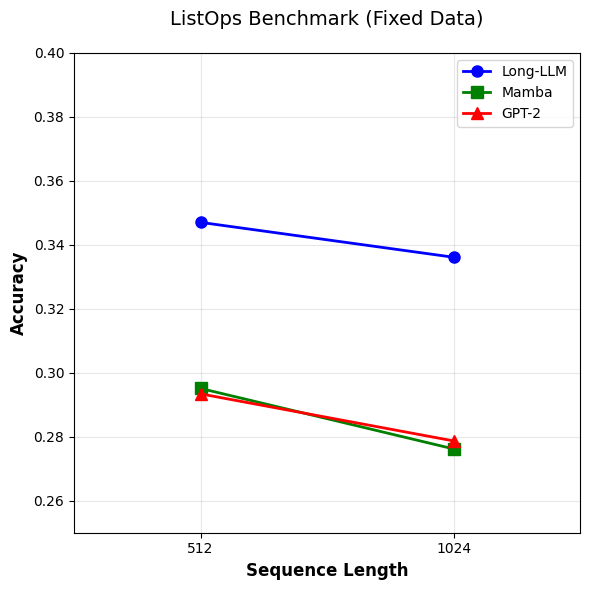

In [28]:
import matplotlib.pyplot as plt

CONTEXT_LENGTHS = [512, 1024]

# --- Plotting Results ---
plt.figure(figsize=(6, 6)) 
colors = ['b', 'g', 'r', 'c', 'm']
markers = ['o', 's', '^', 'D', 'v']

x_labels = [str(x) for x in CONTEXT_LENGTHS]

for idx, model_name in enumerate(results):
    val = results[model_name]
    
    if hasattr(val, '__len__') and len(val) == len(CONTEXT_LENGTHS):
        plt.plot(x_labels, val, 
                 label=model_name,
                 color=colors[idx % len(colors)],
                 marker=markers[idx % len(markers)],
                 linewidth=2,
                 markersize=8)
    else:
        print(f"Skipping '{model_name}' - Value: {val} | Type: {type(val)}")

plt.xlabel("Sequence Length", fontsize=12, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12, fontweight='bold')
plt.title("ListOps Benchmark (Fixed Data)", fontsize=14, pad=20)

# FIXED: Zoomed in the y-axis to tightly fit your data (0.25 to 0.40)
plt.ylim(0.25, 0.40)

plt.margins(x=0.5)
plt.grid(True, alpha=0.3)

if plt.gca().get_legend_handles_labels()[0]:
    plt.legend()

plt.tight_layout()
plt.savefig("listops_zoomed.jpg")
plt.show()